In [1]:
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
from IPython.display import display
import numpy as np
import qutip as qt
import qinfer as qi

## PART I: Basis selection
We choose the single-qubit Pauli basis: $$B = [\mathbb{1}, \sigma_x, \sigma_y, \sigma_z]$$

In [3]:
basis = qi.tomography.pauli_basis(1)
display(basis)

<TomographyBasis pauli_basis dims=[2] at 0x1350628f0>

In [4]:
I, X, Y, Z = qt.qeye(2), qt.sigmax(), qt.sigmay(), qt.sigmaz()

In [5]:
display(basis.state_to_modelparams(I/2 + X/2))

array([0.70710678, 0.70710678, 0.        , 0.        ])

In [6]:
display(basis.modelparams_to_state(np.array([1, 0, 0, 1]))/np.sqrt(2))

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[1. 0.]
 [0. 0.]]

## Part II: Model identification
Since the system is a qubit, it has two possible different physical states, hence, a good model choice is a Bernoulli model for a single shot. If we assume we are able to prepare N different iid replicates, then, the resulting model is a Binomial model. 

Here we define a binomial model in the Pauli basis.

In [7]:
model = qi.BinomialModel(qi.tomography.TomographyModel(basis))

In [8]:
display(model)

In [9]:
display(model.expparams_dtype)

[('meas', float, 4), ('n_meas', 'uint')]

The parameters correspondo to:

- $| M \rangle \rangle = [\langle \langle B_0 | M \rangle \rangle, \langle \langle B_1 | M \rangle \rangle, \langle \langle B_2 | M \rangle \rangle, \langle \langle B_3 | M \rangle \rangle]$
- N : The number of performed measurements 

For example, consider N = 40 replicates of the measurement $$\frac{\mathbb{1} + \sigma_z}{2},$$

then, the parameter write:

In [10]:
expparams = np.array(
    [([1 / np.sqrt(2), 0, 0, 1 / np.sqrt(2)],
      40)], 
    dtype = model.expparams_dtype
                    )

In [11]:
display(expparams)

array([([0.70710678, 0.        , 0.        , 0.70710678], 40)],
      dtype=[('meas', '<f8', (4,)), ('n_meas', '<u8')])

In [12]:
display(expparams['meas'])

array([[0.70710678, 0.        , 0.        , 0.70710678]])

## Part III: Prior Setting
We set a GiniRedit Ensemble, that is an ensamble of redits, this is systems constrained the have $\rho$ st $Tr(\rho) = 1.$ In this case, we consider the redits on the X and Z bases (positions 1, 3)

**Rebit**: Any of an arbitrary number of quantum mechanical binary states that are maximally entangled with every other one (in the real-vector-space theory).

**Maximally mixed state**: Given an orthonormal basis $\{ | \psi \rangle_k \}_{k=1}^K$ s.t. $\rho = \sum_{k=1}^K \lambda_k | \psi \rangle_k$, a state is maximally mixed if $\lambda \sim Uniform(k)$, i.e. $\lambda_k = 1/K$ for all $k=1,2, \dots, K$.

**Maximally entangled state**: A state that is not separable and has maximum entanglement.

In [13]:
fiducial_prior = qi.tomography.GinibreReditDistribution(basis)

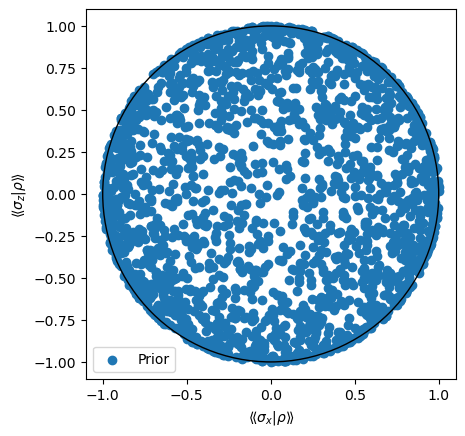

In [14]:
## To male it work change line 166 in
## /site-packages/qinfer/tomography/plotting_tools.py to
## pallette = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
## '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

qi.tomography.plotting_tools.plot_rebit_prior(fiducial_prior, rebit_axes=[1, 3])

In [15]:
prior_mean = (I + (2/3) * Z + (1/3) * X) / 2
display(prior_mean)

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0.83333333 0.16666667]
 [0.16666667 0.16666667]]

In [16]:
prior = qi.tomography.GADFLIDistribution(fiducial_prior, prior_mean)

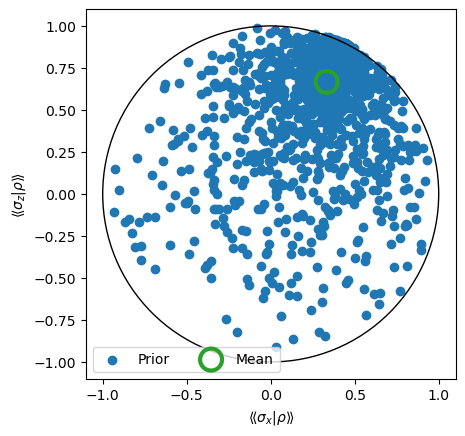

In [17]:
qi.tomography.plotting_tools.plot_rebit_prior(prior, rebit_axes=[1, 3])

## Part IV : SMC
We create a true state: $$\rho = \frac{\mathbb{1}}{2} + \frac{2}{3} \frac{\sigma_Z}{2},$$ and assume a prior mean $$\rho_\mu = \frac{1}{2}\mathbb{1} + \frac{4}{5} \sigma_Z + \frac{1}{7} \sigma_X.$$

In [18]:
basis = qi.tomography.pauli_basis(1)
model = qi.BinomialModel(qi.tomography.TomographyModel(basis))
true_state = basis.state_to_modelparams(I/2 + (2/3) * Z / 2)[np.newaxis, :]

In [19]:
fiducial_prior = qi.tomography.GinibreReditDistribution(basis)

In [20]:
prior = qi.tomography.GADFLIDistribution(fiducial_prior, I/2 + (4/5) * Z/2 + (1/7)*X/2)

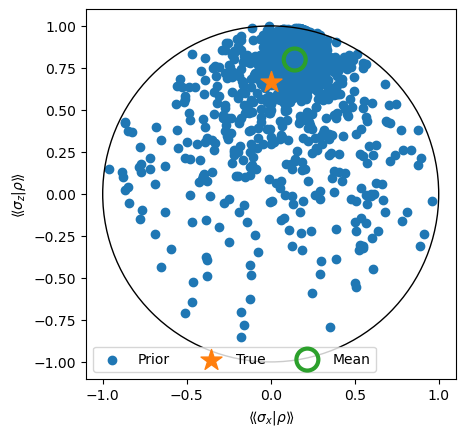

In [21]:
qi.tomography.plotting_tools.plot_rebit_prior(prior, true_state=true_state, rebit_axes=[1,3])

We sample 2000 SMC samples.

In [22]:
updater = qi.smc.SMCUpdater(model, 2000, prior)
heuristic = qi.tomography.RandomPauliHeuristic(updater, other_fields={"n_meas": 40})

We compute the posterior in each step.

In [23]:
for idx_exp in range(50):
    experiment = heuristic()
    datum = model.simulate_experiment(true_state, experiment)
    updater.update(datum, experiment)

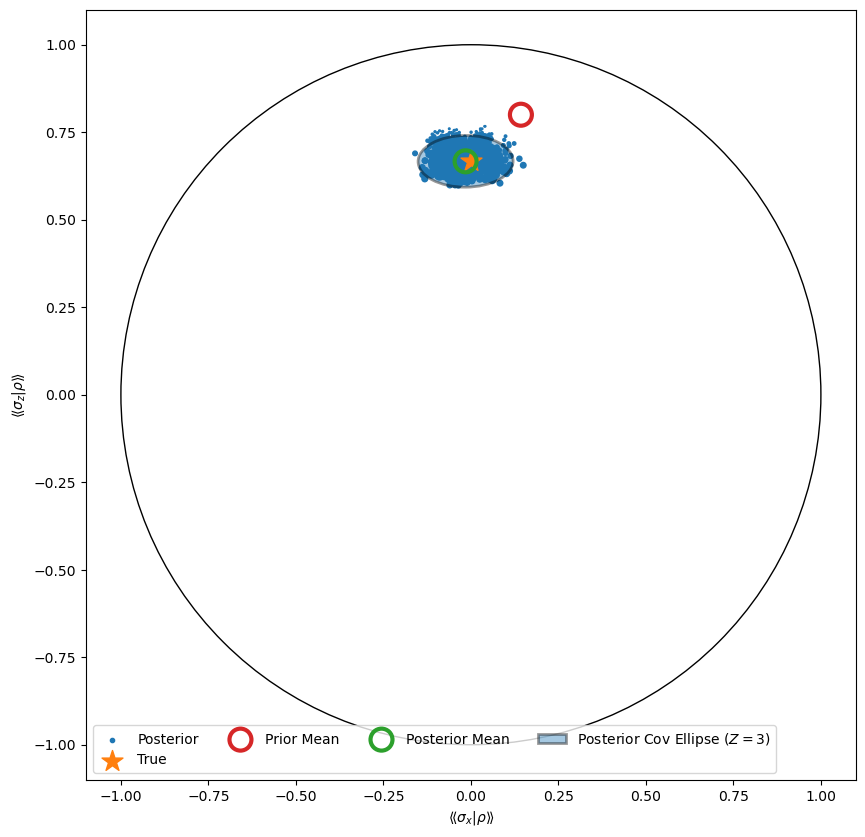

In [24]:
## To male it work change line 166 in
## /site-packages/qinfer/tomography/plotting_tools.py to
## pallette = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

plt.figure(figsize=(10,10))
qi.tomography.plotting_tools.plot_rebit_posterior(updater, prior, true_state, rebit_axes=[1, 3])

In [25]:
est_mean = basis.modelparams_to_state(updater.est_mean())
display(est_mean)

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 0.83342522 -0.00758646]
 [-0.00758646  0.16657478]]

In [26]:
cov_superop = basis.covariance_mtx_to_superop(updater.est_covariance_mtx())
display(qt.to_choi(cov_superop))
display(cov_superop.norm('tr'))

Quantum object: dims = [[[2], [2]], [[2], [2]]], shape = (4, 4), type = super, isherm = True, superrep = choi
Qobj data =
[[ 1.51430085e-04  2.28051220e-06  2.28051220e-06  5.11278377e-04]
 [ 2.28051220e-06 -1.51430085e-04  5.11278377e-04 -2.28051220e-06]
 [ 2.28051220e-06  5.11278377e-04 -1.51430085e-04 -2.28051220e-06]
 [ 5.11278377e-04 -2.28051220e-06 -2.28051220e-06  1.51430085e-04]]

0.001325416933466043

## Part V: Final estimation visualization

(<Figure size 800x600 with 2 Axes>, <AxesSubplot: >)

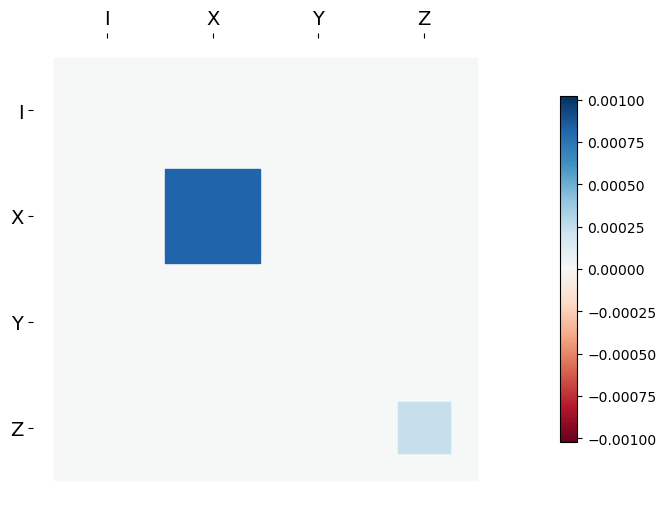

In [27]:
display(qt.visualization.hinton(cov_superop))